In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-02-06 08:57:20.430137: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 08:57:21.044468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-06 08:57:21.044547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-06 08:57:21.044555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Max mutual information vs sampling density for different samples

In [15]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36] 
num_bootstrap_samples = 11
upsampling_factor = 16
max_epochs = 5000
min_background = 30

confidence = 90
num_nyquist_samples = 16
object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

# Fro debugging
# object_names = ['delta_uniform',]
max_epochs = 1000
# # num_nyquist_samples = 16
num_samples_list = [1, 4, 9, 16, 25, 36] 
num_bootstrap_samples = 1



upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_8_delta = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


# for debugging
fake_images_dict = {}
output_signals_dict = {}



mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  if name == 'delta_uniform':
    objects_fn = objects_fn_delta
  elif name == '8_deltas_uniform':
    objects_fn = objects_fn_8_delta
  else:
    objects_fn = objects_fn_white_noise



  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):
        # Find an optimal PSF for this object
      initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

      # do the estimation
      scale_factor = 100000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # make strictly positive
      resampled_output_signals -= np.min(resampled_output_signals)
    
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      # make strictly positive
      noisy_pixelated_signals -= np.min(noisy_pixelated_signals)


      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      fake_images += min_background

      fake_images_dict[name] = fake_images
      output_signals_dict[name] = output_signals

      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(name, ': ', mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise


  0%|          | 0/6 [00:00<?, ?it/s]

initial loss -0.1522882268171704
computing optimized mi


 17%|█▋        | 1/6 [01:11<05:57, 71.45s/it]

white_noise :  -0.04247396413370657
initial loss -0.10375335572657537
computing optimized mi


 33%|███▎      | 2/6 [02:51<05:54, 88.50s/it]

white_noise :  3.248680286521837
initial loss -0.1452160811075387
computing optimized mi


 50%|█████     | 3/6 [04:18<04:23, 87.68s/it]

white_noise :  3.611750771099798
initial loss -0.1550623198644871
computing optimized mi


 67%|██████▋   | 4/6 [05:35<02:46, 83.31s/it]

white_noise :  3.4237152827243236
initial loss -0.21366792622070824
computing optimized mi


 83%|████████▎ | 5/6 [06:46<01:19, 79.08s/it]

white_noise :  2.3341604361319086
initial loss -0.15265889966034826
computing optimized mi


100%|██████████| 6/6 [07:50<00:00, 78.38s/it]


white_noise :  1.6832914180315999
delta_uniform


  0%|          | 0/6 [00:00<?, ?it/s]

initial loss -4.192255005728695
computing optimized mi


 17%|█▋        | 1/6 [01:03<05:18, 63.66s/it]

delta_uniform :  -0.011881690198230169
initial loss -3.678277512452059
computing optimized mi


 33%|███▎      | 2/6 [02:47<05:50, 87.57s/it]

delta_uniform :  4.322989865123872
initial loss -4.3306536585901165
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [04:11<04:17, 85.90s/it]

delta_uniform :  3.0558588159525795
initial loss -4.029271381089515
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 67%|██████▋   | 4/6 [05:48<03:00, 90.11s/it]

delta_uniform :  1.6788370932409573
initial loss -3.3429836820422887
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.09% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [07:10<01:27, 87.16s/it]

delta_uniform :  1.1281314090258596
initial loss -3.6436572000940166
computing optimized mi


100%|██████████| 6/6 [08:24<00:00, 84.08s/it]


delta_uniform :  0.8216686561679803
8_deltas_uniform


  0%|          | 0/6 [00:00<?, ?it/s]

initial loss -2.5451577137103403
computing optimized mi


 17%|█▋        | 1/6 [01:22<06:54, 82.83s/it]

8_deltas_uniform :  -0.012977563649527984
initial loss -2.796119121667595
computing optimized mi


 33%|███▎      | 2/6 [03:08<06:24, 96.10s/it]

8_deltas_uniform :  4.65305621693736
initial loss -2.325393576845288
computing optimized mi


 50%|█████     | 3/6 [04:44<04:47, 95.96s/it]

8_deltas_uniform :  5.015961598170493
initial loss -2.616314871028264
computing optimized mi


 67%|██████▋   | 4/6 [06:28<03:18, 99.38s/it]

8_deltas_uniform :  4.835105353572636
initial loss -2.5477653602509207
computing optimized mi


 83%|████████▎ | 5/6 [07:45<01:31, 91.16s/it]

8_deltas_uniform :  3.224292418063754
initial loss -2.583139732673007
computing optimized mi


100%|██████████| 6/6 [08:50<00:00, 88.38s/it]

8_deltas_uniform :  2.239475743685285


In [7]:
mi_estimate1 = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
fake_images_2 = fake_images 
mi_estimate2 = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      

print(mi_estimate1, mi_estimate2)


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.92% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


1.0948769018064246 5.0547939482570765


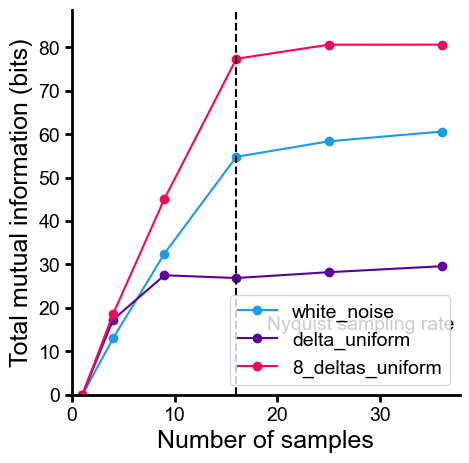

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi, 'o-', label=object_name)
    ax.fill_between(num_samples_list, np.array(mi_by_object_lo[object_name]) * np.array(num_samples_list), 
                            np.array(mi_by_object_hi[object_name]) * np.array(num_samples_list), alpha=0.4)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])), xlim=(0, ax.get_xlim()[1]))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_sampling_density' + '.pdf', transparent=True)
